In [1]:
import numpy as np
import cv2
from jColor.Image import Image
from jColor.Color import Color
from scipy.stats import norm, gaussian_kde
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

In [2]:
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.serif"] = "Nimbus Roman"

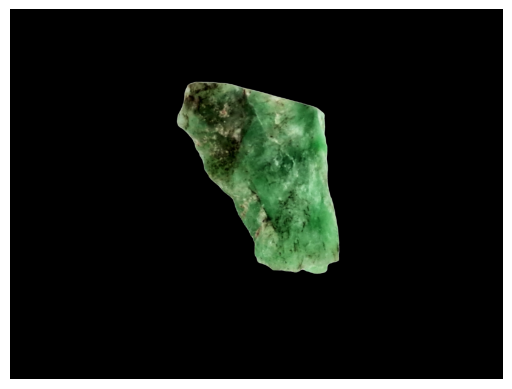

In [8]:
jImg = Image('imgs/M2.jpg')
nJimg, wMean, bMask = jImg.RGB_Normalization()
plt.imshow(nJimg)
plt.axis('off')
plt.show()

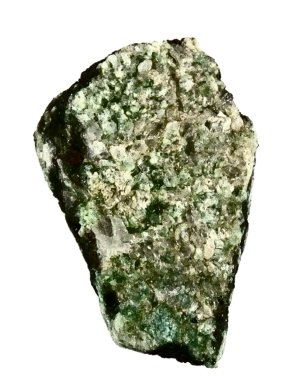

In [23]:
Img = cv2.bitwise_and(jImg.features['array'],jImg.features['array'],mask = bMask)
Img = cv2.GaussianBlur((nJimg*255).astype(np.uint8), (1,1),0)
nLab = cv2.cvtColor(Img,cv2.COLOR_RGB2LAB)
LImg, aImg, bImg = cv2.split(nLab)
eqL = cv2.equalizeHist(LImg)
LabEq = cv2.merge((eqL,aImg,bImg))
EQImg = cv2.cvtColor(LabEq,cv2.COLOR_LAB2RGB)
plt_img = np.ones_like(EQImg)*255
plt_img[bMask != 0] = EQImg[bMask != 0]

#plt.figure(figsize = (10,8),dpi = 300)
#plt.imshow(jImg.features['array'])
plt.imshow(plt_img)
plt.axis('off')
plt.show()

In [ ]:
Img = cv2.bitwise_and(jImg.features['array'],jImg.features['array'],mask = bMask)
Img = cv2.GaussianBlur(Img, (3,3),0)/wMean 
pColor = Color(Img)
nLab = pColor.Lab
LImg, aImg, bImg = cv2.split(nLab)
eqL = cv2.equalizeHist(LImg.astype(np.uint8))
LabEq = np.stack((eqL, aImg, bImg), axis = 2)#cv2.merge
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(Img)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(eqL, cmap = 'nipy_spectral')
plt.axis('off')
plt.show()

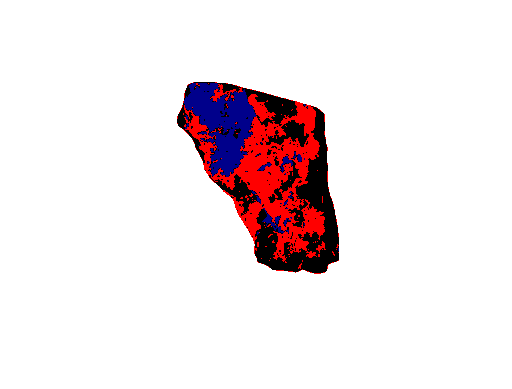

In [9]:
pColor = Color(nJimg).Lab
LImg, aImg, bImg = cv2.split(pColor)
rows, columns = LImg.shape

data = np.column_stack((LImg[bMask != 0],aImg[bMask != 0],bImg[bMask != 0]))
kmeans = KMeans(n_clusters = 3, init="k-means++",random_state=0,n_init=10)
kmeans.fit(data)
cls = np.sort(kmeans.cluster_centers_)

rMask = np.ones_like(LImg)*3
rMask[bMask != 0] = kmeans.labels_

colors = ['darkblue','black','red', 'white']  
cmap = ListedColormap(colors)

#plt.figure(figsize = (10,8),dpi = 300)
plt.imshow(rMask, cmap)
plt.axis('off')
plt.show()

100.0


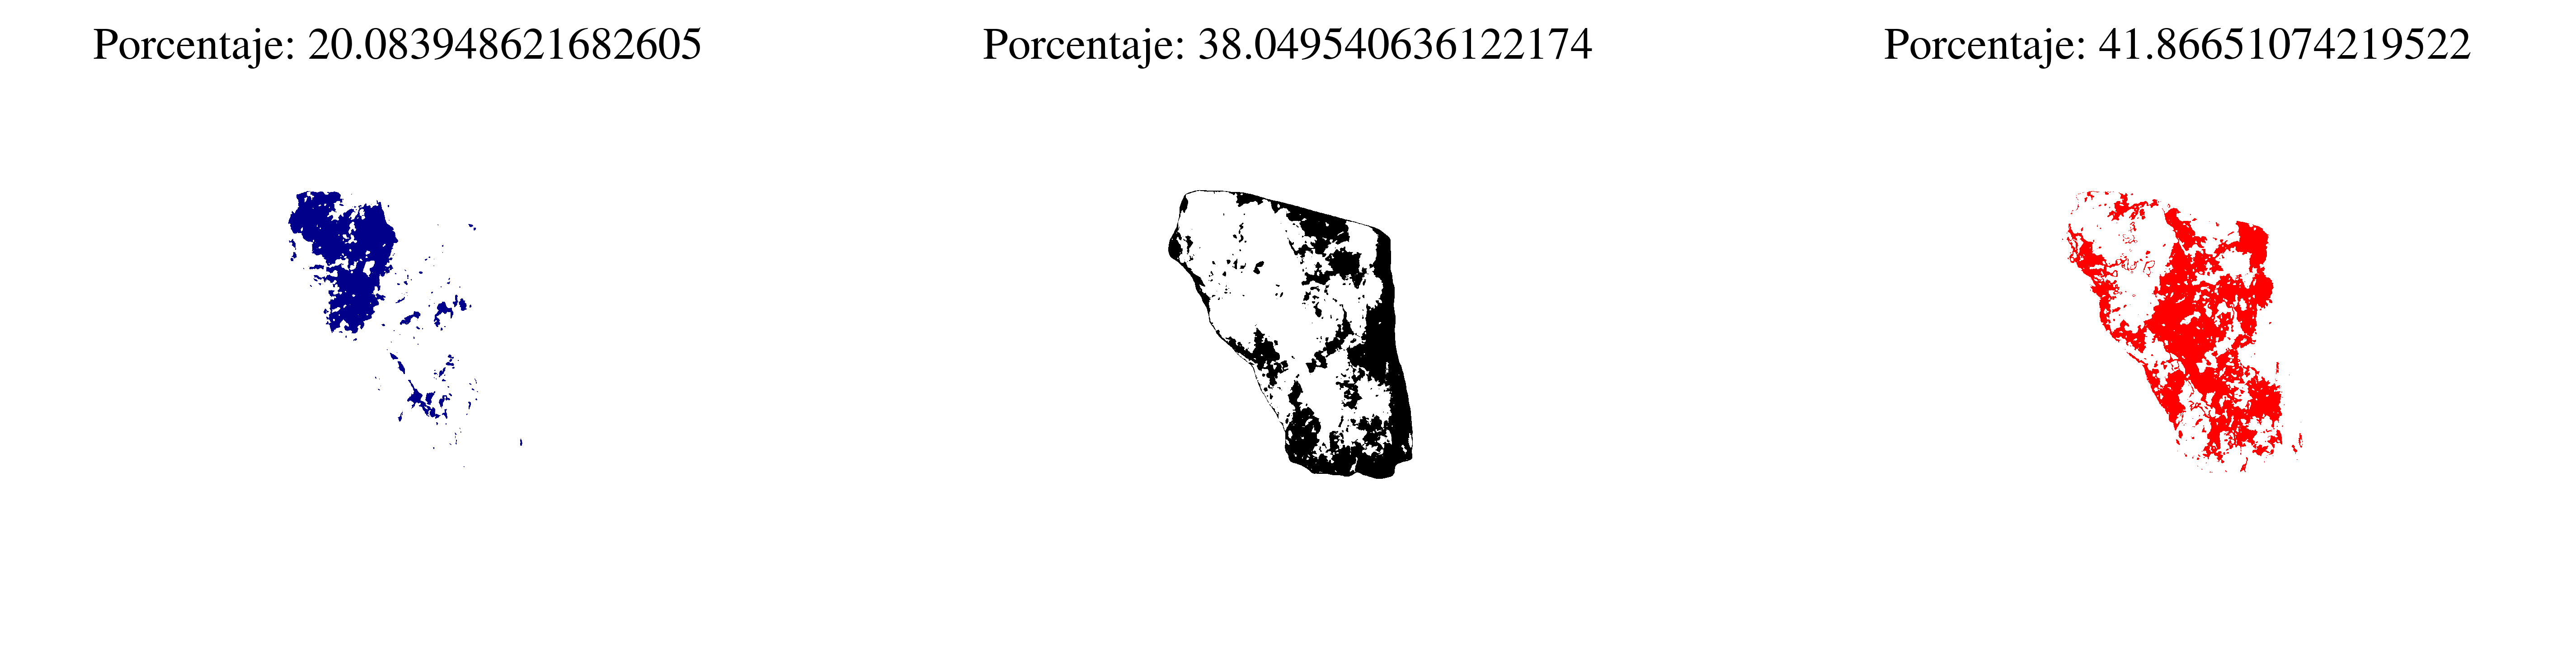

In [10]:
plt.figure(figsize = (12,5), dpi= 600)
total_ = 0

data = []
for i in range(3):
    
    bColors = ['white', colors[i]]
    bmap = ListedColormap(bColors)
    map_ = np.zeros_like(LImg)
    map_[rMask == i] =  1
    sLab = pColor[rMask == i]
    sample = np.sum(map_)
    total = np.sum(bMask)
    percent = (sample/total) * 100
    total_ += percent

    info = {'mean': sLab.mean(axis = 0),
            'std': sLab.std(axis  = 0),
            'max': sLab.max(axis = 0),
            'min': sLab.min(axis = 0),
            'var': sLab.var(axis = 0),
            'mse': (sLab.std(axis  = 0)/np.sqrt(len(sLab)))**2,
            'median': np.median(sLab,axis = 0),
            'percent':percent,
            'size_n': len(sLab)}
    
    data.append(info)


    plt.subplot(1,3,i+1)
    plt.title(f'Porcentaje: {percent}', fontname = 'Nimbus Roman')
    plt.imshow(map_,bmap)
    plt.axis('off')

print(total_)
plt.show()

In [11]:
samples = ['A','B','C']

with pd.ExcelWriter('datos_M2_.xlsx') as writer:
    for i,s in enumerate(data):
        df = pd.DataFrame(s,index = ('L','a','b'))
        df.to_excel(writer,sheet_name = samples[i])


In [21]:
mse = np.array([i['mse'] for i in data])
n = np.array([i['size_n'] for i in data])
var = np.array([i['var'] for i in data])

mse*100

array([[0.02553067, 0.0123861 , 0.005585  ],
       [0.00787817, 0.00993279, 0.00284128],
       [0.00636399, 0.00549519, 0.00121782]])

In [17]:
cData = [LImg, aImg, bImg]
sheet_names = ['L','a','b']
with pd.ExcelWriter('datos_gauss_M3.xlsx') as writer:

    for k, aData in enumerate(cData):
        mean_ = np.array([i['mean'] for i in data])[:,k]
        std_ = np.array([i['std'] for i in data])[:,k]

        datos = []
                
        #colors = ['black','red','darkblue', 'white']  
        colors = ['darkblue','black',   'red', 'white']  

        Ldata = aData[bMask != 0]

        hist, bins = np.histogram(Ldata, bins=100, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        #plt.bar(bin_centers, hist, width=bins[1] - bins[0], alpha=0.6)
        x = np.linspace(np.amin(Ldata), np.amax(Ldata), 1000)

        kde = gaussian_kde(Ldata)
        density_real = kde(x)
        datos.append(x)
        datos.append(density_real)


        density_max = np.max(density_real)
        for i,m in enumerate(mean_):
            gauss_density = norm.pdf(x, m, std_[i])
            gauss_density_scaled = gauss_density * (density_real[np.argmax(gauss_density)] / np.max(gauss_density))
            #plt.plot(x, gauss_density_scaled,colors[i])
            datos.append(gauss_density_scaled)

        df = pd.DataFrame(np.array(datos).T,columns = ('x','Density','A','B','C'))
        df.to_excel(writer,sheet_name = sheet_names[k])

In [ ]:
plt.plot(x, density_real, c = 'green')
plt.ylabel('density (u.a)', fontsize = 15)
plt.xlabel('L (u.a)', fontsize = 15)
plt.title('Density diagram (L)')
plt.ylim(0)
plt.show()

In [69]:
pColor_sample = Color(nJimg)
nLab_sample = pColor_sample.Lab
nL = nLab_sample[:,:,0]

15.42303782236146
35.24554451337165
49.331417664266894
100.0


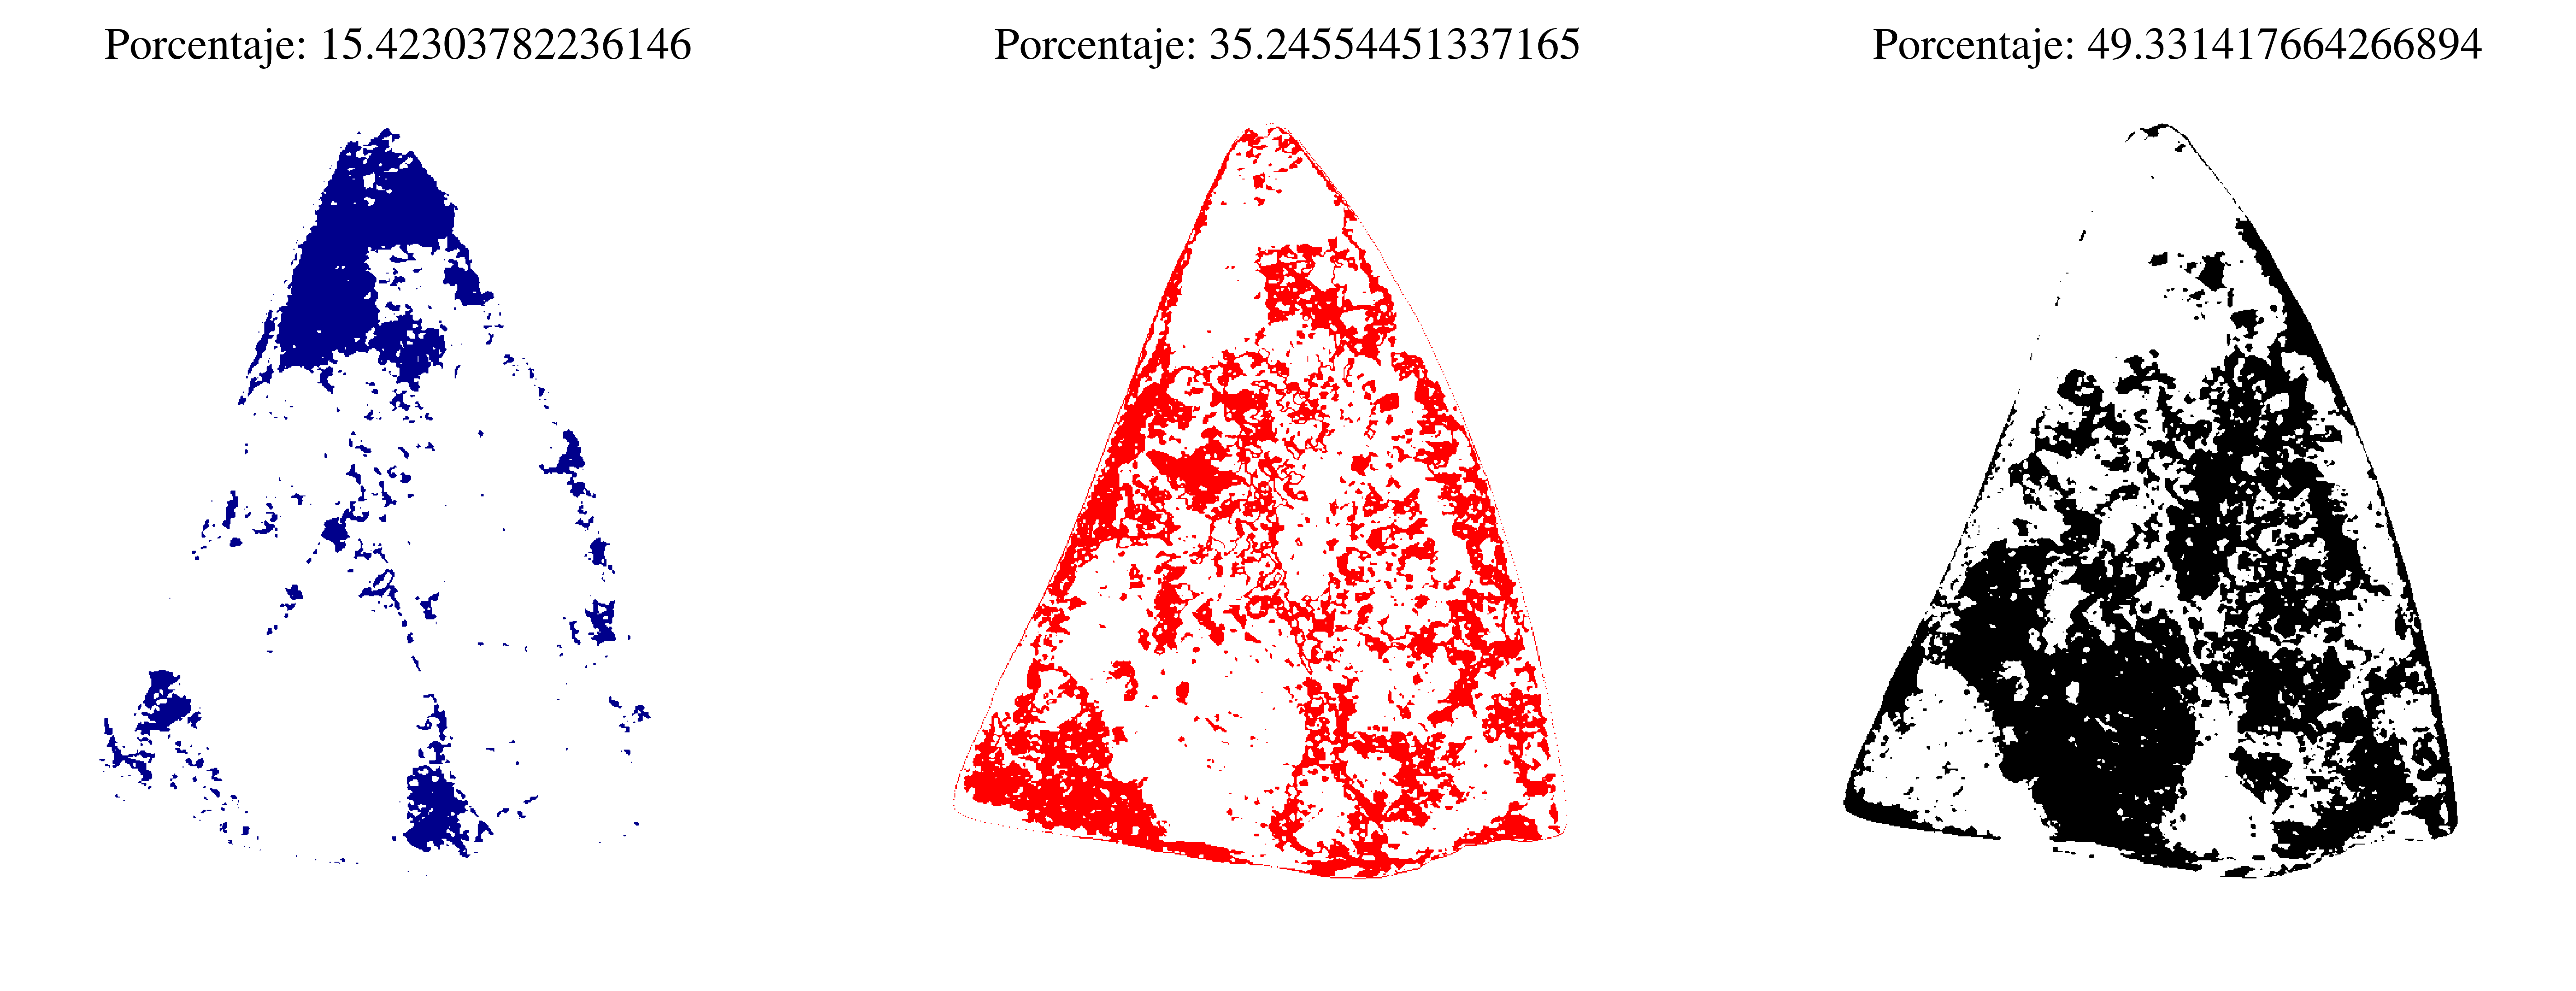

In [72]:
limits = [-5, cls[0]-1,cls[1],1000]
total_ = 0

mean = []
std = []
plt.figure(figsize = (12,5), dpi= 600)
for i in range(3):
    bColors = ['white', colors[i+1]] 
    bmap = ListedColormap(bColors)
    map_ = np.zeros_like(eqL)
    mask = np.concatenate(np.clip(cv2.inRange(eqL[bMask != 0], lowerb = limits[i], upperb = limits[i+1]),0,1))
    map_[bMask != 0] = mask
    sample = np.sum(mask)
    total = np.sum(bMask)
    percent = (sample/total) * 100
    mean.append(nLab_sample[bMask != 0][mask != 0].mean(0))
    std.append(nLab_sample[bMask != 0][mask != 0].std(0))
    total_ += percent
    plt.subplot(1,3,i+1)
    plt.title(f'Porcentaje: {percent}', fontname = 'Nimbus Roman')
    plt.imshow(map_,bmap)
    plt.axis('off')
    print(percent)

print(total_)
plt.show()

In [111]:
mean, std

([array([24.50895628, -4.02141747,  4.86745224]),
  array([ 45.5720991 , -10.99853884,   9.76998955]),
  array([ 66.13191683, -16.36569093,   9.61636118])],
 [array([10.21068135,  5.10706295,  4.62692175]),
  array([5.77137651, 8.61303038, 5.80240267]),
  array([9.4134388 , 9.79036418, 5.15439181])])

In [9]:
mean_ = np.array(mean)[:,0]
std_ = np.array(std)[:,0]

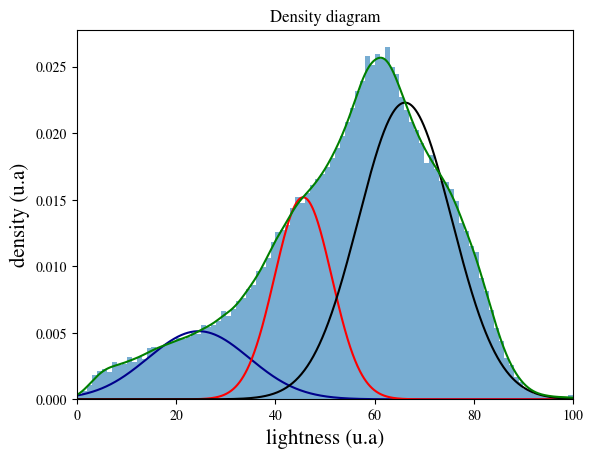

In [10]:
Ldata = nL[bMask != 0]

hist, bins = np.histogram(Ldata, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.bar(bin_centers, hist, width=bins[1] - bins[0], alpha=0.6)
x = np.linspace(np.amin(Ldata), np.amax(Ldata), 1000)

kde = gaussian_kde(Ldata)
density_real = kde(x)

density_max = np.max(density_real)
for i,m in enumerate(mean_):
    gauss_density = norm.pdf(x, m, std_[i])
    gauss_density_scaled = gauss_density * (density_real[np.argmax(gauss_density)] / np.max(gauss_density))
    plt.plot(x, gauss_density_scaled,colors[i+1])

plt.plot(x, density_real, c = 'green')
plt.ylabel('density (u.a)', fontsize = 15)
plt.xlabel('lightness (u.a)', fontsize = 15)
plt.title('Density diagram')
plt.xlim(0,100)
plt.ylim(0)
plt.show()

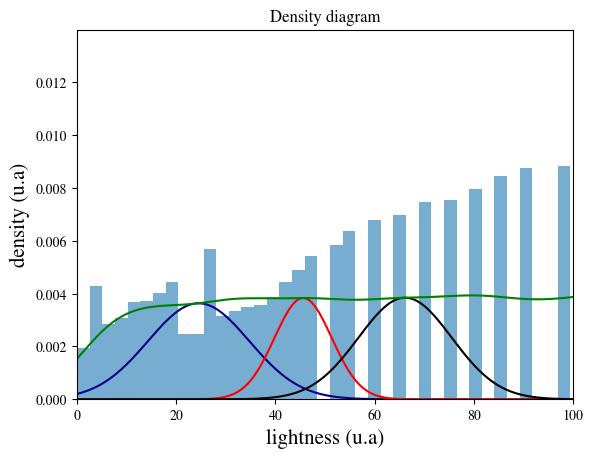

In [12]:
Ldata = L[bMask != 0]

hist, bins = np.histogram(Ldata, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.bar(bin_centers, hist, width=bins[1] - bins[0], alpha=0.6)
x = np.linspace(np.amin(Ldata), np.amax(Ldata), 1000)

kde = gaussian_kde(Ldata)
density_real = kde(x)

density_max = np.max(density_real)
for i,m in enumerate(mean_):
    gauss_density = norm.pdf(x, m, std_[i])
    gauss_density_scaled = gauss_density * (density_real[np.argmax(gauss_density)] / np.max(gauss_density))
    plt.plot(x, gauss_density_scaled,colors[i+1])

plt.plot(x, density_real, c = 'green')
plt.ylabel('density (u.a)', fontsize = 15)
plt.xlabel('lightness (u.a)', fontsize = 15)
plt.title('Density diagram')
plt.xlim(0,100)
plt.ylim(0)
plt.show()

In [88]:
np.argmax(gauss_density)

np.int64(691)

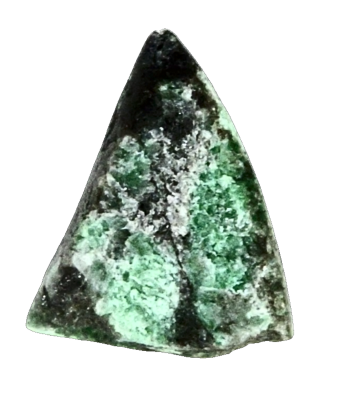

In [10]:
Img = cv2.bitwise_and(jImg.features['array'],jImg.features['array'],mask = bMask)
gImg = cv2.GaussianBlur(Img, (3,3),0) 
aImg = cv2.cvtColor(gImg, cv2.COLOR_RGB2LAB)

eqImg = cv2.equalizeHist(aImg[:,:,0])
eqImg = cv2.merge((eqImg, aImg[:,:,1],aImg[:,:,2]))
eqImg = cv2.cvtColor(eqImg, cv2.COLOR_Lab2RGB)
eqImg = eqImg#/ 255

reRGB = np.ones_like(Img)*255
reRGB[bMask != 0] = eqImg[bMask != 0]
plt.figure(figsize = (8,5))

#plt.subplot(1,2,1)
#plt.imshow(gImg)
#plt.axis('off')

#plt.subplot(1,2,2)
plt.imshow(reRGB)
plt.axis('off')
plt.show()

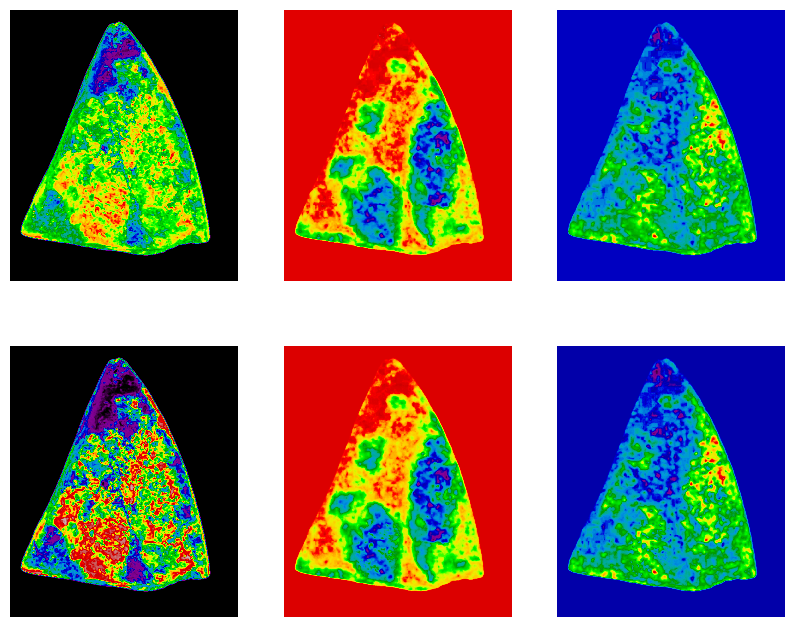

In [4]:
LabEq = Color(eqImg).Lab
Lab = Color(nJimg).Lab

plt.figure(figsize = (10,8))

for i in range(6):
    plt.subplot(2,3,i+1)
    if i <= 2:
        plt.imshow(Lab[:,:,i], cmap = 'nipy_spectral')
    else:
        plt.imshow(LabEq[:,:,i-3], cmap = 'nipy_spectral')
    plt.axis('off')

plt.show()

[24.73148465 51.6170723  70.69747431]


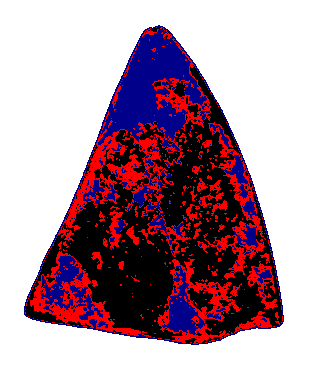

In [8]:
rows, columns, _ = LabEq.shape
data = Lab.reshape(-1,3)

data_ = data[bMask.reshape(-1) != 0]
kmeans = KMeans(n_clusters = 3, init="k-means++",random_state=0,n_init=10)
kmeans.fit(data_)
cls = np.sort(kmeans.cluster_centers_[:,0])
print(cls)
 #Jadeita: ROJO, ompacita: Azul, albita: negro

colors = ['white', 'darkblue', 'red', 'black']  
bounds = [-1,0.01, cls[0], cls[1],100] 
cmap = ListedColormap(colors)
cm = BoundaryNorm(bounds, cmap.N)
plt.imshow(LabEq[:,:,0],cmap = cmap, norm = cm)
plt.axis('off')
plt.show()

Mejor número de gaussianas: 4
mean: 59.640458392846625, std: 6.065864276866392
mean: 43.379370939107496, std: 7.135856981035372
mean: 74.36479129253857, std: 6.961319520295685
mean: 20.778500488961797, std: 9.48456205347236


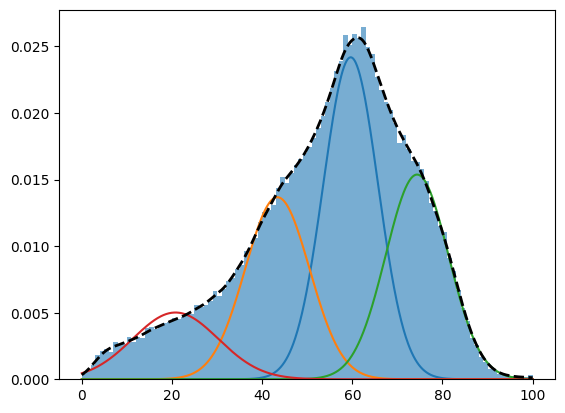

In [9]:
data = Lab[bMask !=0][:,0]
hist, bins = np.histogram(data, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.bar(bin_centers, hist, width=bins[1] - bins[0], alpha=0.6)

bic = []
n_components_range = range(1, 10)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data.reshape(-1, 1))
    bic.append(gmm.bic(data.reshape(-1, 1)))

best_n_components = n_components_range[np.argmin(bic)]
print(f"Mejor número de gaussianas: {best_n_components}")

gmm = GaussianMixture(n_components = best_n_components)
gmm.fit(data.reshape(-1, 1))

x = np.linspace(min(data), max(data), 1000)
for i in range(gmm.n_components):
    mean = gmm.means_[i, 0]
    std = np.sqrt(gmm.covariances_[i, 0, 0])
    gauss_density = norm.pdf(x, mean, std)
    gauss_scaled = gauss_density * gmm.weights_[i]
    plt.plot(x, gauss_scaled)
    print(f'mean: {mean}, std: {std}')
kde = gaussian_kde(data)
density_real = kde(x)

plt.plot(x, density_real, c = 'black', lw = 2, linestyle = '--')
plt.show()

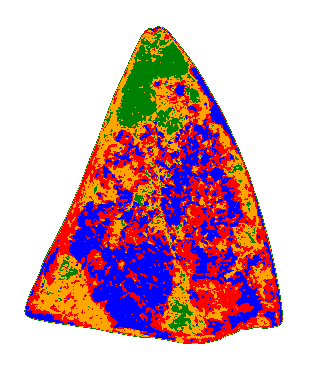

In [10]:
colors = ['white', 'green', 'orange', 'red','blue']  
bounds = [0,1, 30, 51,65,100] 
cmap = ListedColormap(colors)
cm = BoundaryNorm(bounds, cmap.N)

plt.imshow(Lab[:,:,0], cmap =  cmap, norm= cm)
plt.axis('off')
plt.show()